#Apex

In [0]:
!git clone https://github.com/NVIDIA/apex
!cd apex && \
pip install -v --no-cache-dir ./

#Vanilla
The folowing demo uses scripts from NVIDIA's implementation of Tacotron2 and WaveGLOW https://github.com/NVIDIA/DeepLearningExamples/tree/1cad1801646dee0e96e344b43c796181d6f05564/PyTorch/SpeechSynthesis/Tacotron2

##Setup

In [0]:
!git clone https://github.com/NVIDIA/DeepLearningExamples.git
!cd DeepLearningExamples/PyTorch/SpeechSynthesis/Tacotron2 && \
pip install -r requirements.txt

In [0]:
!mkdir vanilla_models
!mkdir output
!mkdir phrases

In [0]:
!wget https://api.ngc.nvidia.com/v2/models/nvidia/tacotron2pyt_fp16/versions/3/files/tacotron2_1032590_6000_amp -O vanilla_models/tacotron2.pt
!wget https://api.ngc.nvidia.com/v2/models/nvidia/waveglow256pyt_fp16/versions/2/files/waveglow_1076430_14000_amp -O vanilla_models/waveglow.pt

##Sentence

In [0]:
%%writefile phrases/phrase.txt
This is a demo for text to speech using wave glow.

##Inference

In [0]:
!cd DeepLearningExamples/PyTorch/SpeechSynthesis/Tacotron2 && \
python inference.py --tacotron2 /content/vanilla_models/tacotron2.pt --waveglow /content/vanilla_models/waveglow.pt --wn-channels 256 -o /content/output/ -i /content/phrases/phrase.txt --amp-run

## Audio

In [14]:
from IPython.display import Audio
Audio('/content/output/audio_0_.wav')

#Emotional
The following demo uses scripts from our SRU course project https://github.com/Emotional-Text-to-Speech/dl-for-emo-tts and NVIDIA's implementation of WaveGLOW https://github.com/NVIDIA/waveglow.git <br>
The code builds on the colab notebook https://colab.research.google.com/github/Emotional-Text-to-Speech/dl-for-emo-tts/blob/master/Demo_DL_Based_Emotional_TTS.ipynb

## Setup

In [0]:
!git clone https://github.com/NVIDIA/waveglow.git
!cd waveglow && \
git submodule init
!cd waveglow && \
git submodule update
!cd waveglow && \
sed -i '1,2d' requirements.txt
!cd waveglow && \
pip install -r requirements.txt
!git clone --recursive https://github.com/Emotional-Text-to-Speech/tacotron_pytorch.git
!cd "tacotron_pytorch/" && pip install -e .
!pip install gdown

In [0]:
!mkdir emotional_models
!mkdir output
!mkdir phrases
!wget https://api.ngc.nvidia.com/v2/models/nvidia/waveglow_ljs_256channels/versions/2/files/waveglow_256channels_ljs_v2.pt -O emotional_models/waveglow.pt
import gdown
url = 'https://drive.google.com/uc?id=1N6Ykrd1IaPiNdos_iv0J6JbY2gBDghod'
output = 'emotional_models/disgust_tacotron.pth'
gdown.download(url, output, quiet=False)
url = 'https://drive.google.com/uc?id=15m0PZ8xaBocb_6wDjAU6S4Aunbr3TKkM'
output = 'emotional_models/amused_tacotron.pth'
gdown.download(url, output, quiet=False)
url = 'https://drive.google.com/uc?id=1D6HGWYWvhdvLWQt4uOYqdmuVO7ZVLWNa'
output = 'emotional_models/sleepiness_tacotron.pth'
gdown.download(url, output, quiet=False)

In [0]:
%tensorflow_version 1.x 
%pylab inline
rcParams["figure.figsize"] = (10,5)

import os
import sys
import numpy as np
sys.path.append('tacotron_pytorch/')
sys.path.append('tacotron_pytorch/lib/tacotron')
sys.path.append('waveglow/')
sys.path.append('waveglow/tacotron2/')

import torch

# For the Tacotron
from text import text_to_sequence, symbols
# from util import audio

from tacotron_pytorch import Tacotron
from synthesis import tts as _tts

# For Audio/Display purposes
from librosa.output import write_wav
import librosa.core
import librosa.display
import IPython
from IPython.display import Audio
from IPython.display import display
from google.colab import widgets
from google.colab import output
import warnings
warnings.filterwarnings('ignore')

In [0]:

model = Tacotron(n_vocab=len(symbols),
                 embedding_dim=256,
                 mel_dim=80,
                 linear_dim=1025,
                 r=5,
                 padding_idx=None,
                 use_memory_mask=False,
                 )

def visualize(spectrogram):
    label_fontsize = 16
    tb = widgets.TabBar(['Spectrogram'], location='top')
    with tb.output_to('Spectrogram'):
        librosa.display.specshow(spectrogram.T, sr=fs,hop_length=hop_length, x_axis="time", y_axis="linear")
        xlabel("Time", fontsize=label_fontsize)
        ylabel("Hz", fontsize=label_fontsize)

def tts_tacotron(model, text):
    waveform, alignment, spectrogram = _tts(model, text)
    return waveform, alignment, spectrogram 

def present(waveform, figures=False):
  if figures!=False:
        visualize(figures[0])
  IPython.display.display(Audio(filename=waveform))

  
fs = 20000 #20000
hop_length = 250
model.decoder.max_decoder_steps = 200

## Sentence + Audio


Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

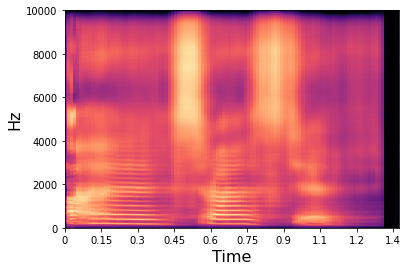

<IPython.core.display.Javascript object>

In [22]:
#@title Select the emotion and type the text
!echo /content/output/emo_out.wav > phrases/test_files.txt
!echo /content/output/emo_out.wav.pt > output/mel_files.txt
!echo /content/output/emo_out.wav > waveglow/train_files.txt

%pylab inline

Emotion = "Sleepiness" #@param ["Disgust", "Sleepiness", "Amused"]
Text = 'I am exhausted.' #@param {type:"string"}

wav, align, mel = None, None, None

is_fp16 = True
denoiser_strength = 0.0

waveglow = torch.load('emotional_models/waveglow.pt')['model']
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow.cuda().eval()

checkpoint = torch.load('emotional_models/'+Emotion.lower()+'_tacotron.pth', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint["state_dict"])
wav, align, mel = tts_tacotron(model, Text)

write_wav('output/emo_out.wav', wav, fs)

!cd waveglow && \
python -W ignore mel2samp.py -f /content/phrases/test_files.txt -o /content/output -c config.json > log.txt
!cd waveglow && \
python3 -W ignore inference.py -f /content/output/mel_files.txt -w /content/emotional_models/waveglow.pt -o /content/output --is_fp16 -s 1.0 > log.txt

present('/content/output/emo_out.wav_synthesis.wav', [mel])